In [1]:
###############################################################
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
###############################################################
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from config import Config
import tensorflow as tf
import model

config = Config()
dataset = model.Dataset(config=config, 
                        path=r'/home/yang/Downloads/COCO-dataset',
                        subset='val2017')

Using TensorFlow backend.


loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
num_of_classes: 81
Number of images: 14631
Number of classes: 81


In [2]:
'''some utility functions'''
def plot_results(image, boxes, masks, classes):
    '''plot image with, boxes, masks and classes'''
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # set colors
    num_instance = boxes.shape[0]
    colors = dataset.random_colors(num_instance)

    # apply mask
    image = batch_image[-1]
    for i in range(num_instance):
        image = dataset.apply_mask(image, 
                                   masks[:,:,i], 
                                   color=colors[i])
    # showbbox:
    for i in range(num_instance):
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                              linewidth=2,
                              alpha=0.7, 
                              linestyle="dashed",
                              edgecolor=colors[i], 
                              facecolor='none')                
        ax.add_patch(p)

        # show class
        ax.text(x1, y1+8, 
                dataset.map_id_to_class_name[classes[i]],
                color='w', size=11, backgroundcolor="none")

    ax.imshow(image)
    plt.show()

In [3]:
'''creat model'''
mr_model = model.MaskRCNN('evaluate', config)

'''load pre-trained weights'''
# mr_model.load_weights(os.path.join(mr_model.root_dir, 'pre_trained_model', 'mask_rcnn_coco.h5'))
mr_model.load_weights(os.path.join(mr_model.root_dir, 'logs/coco_20190322T1257_to_use', 'coco_0002.h5'))

'''generate anchors'''
anchors = model.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                   config.RPN_ANCHOR_RATIOS, 
                                   model.compute_backbone_shapes(config.IMAGE_SHAPE,
                                                          config), 
                                   config.BACKBONE_STRIDES, 
                                   config.RPN_ANCHOR_STRIDE)

Instructions for updating:
Colocations handled automatically by placer.
Feature map size: [256, 256], number of anchors: 49152
Feature map size: [128, 128], number of anchors: 12288
Feature map size: [64, 64], number of anchors: 3072
Feature map size: [32, 32], number of anchors: 768
Feature map size: [16, 16], number of anchors: 192
Total number of anchors:      65472


In [4]:
'''choose an image randomly'''
image_id = np.random.choice(range(dataset.num_of_images), 1)[0]

image = dataset.load_image(image_id)
image,_,_,_ = dataset.resize_image(image, [1024, 1024])

'''add batch dimension'''
anchors = np.expand_dims(anchors, axis=0)
batch_image = np.expand_dims(image, axis=0)

In [5]:
'''make prediciton and extract outputs'''
proposals, detections, mrcnn_class, mrcnn_bbox, mrcnn_masks = mr_model.model.predict([batch_image, anchors])
bboxes = detections[..., :4]
class_ids = detections[..., 4]
scores = detections[..., 5]

'''remove extra dimension'''
bboxes = bboxes[0]
class_ids = class_ids[0]
scores = scores[0]
mrcnn_masks = mrcnn_masks[0]

In [6]:
'''remove zeros padding'''
pos_ids = np.where(np.sum(bboxes, axis=1) != 0)[0]

bboxes = bboxes[pos_ids]
class_ids = class_ids[pos_ids]
scores = scores[pos_ids]

In [7]:
'''get mask indices'''
class_ids = class_ids.astype(np.int32)
ids = np.stack([np.arange(class_ids.shape[0]), class_ids], axis=0)
ids = tuple(ids)
'''extract masks'''
mrcnn_masks = np.round(mrcnn_masks)
pos_masks = mrcnn_masks[pos_ids]
trans_masks = np.transpose(pos_masks, [0,3,1,2])

masks = trans_masks[ids]
masks = np.transpose(masks, [1,2,0])

'''expand minimask to original size'''
original_masks = model.expand_mask(masks, [1024, 1024], bboxes)

/home/yang/.conda/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/yang/.conda/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


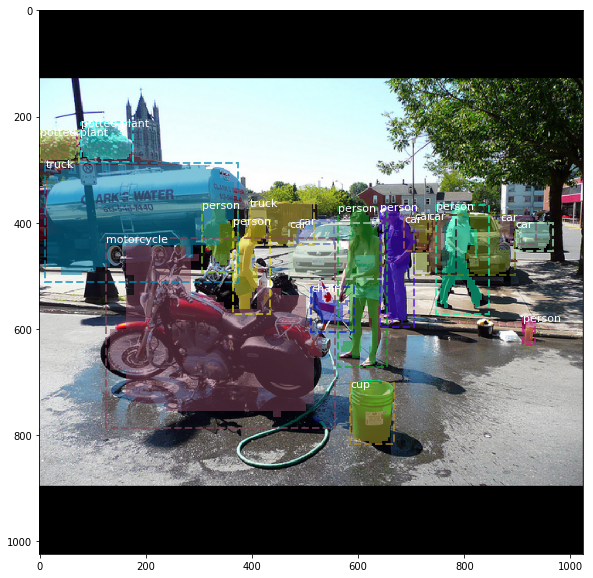

In [8]:
'''plot result'''
plot_results(batch_image[0], bboxes, original_masks, class_ids)